**Trích xuất thông tin dạng bảng trong tài liệu báo cáo tài chính file PDF**

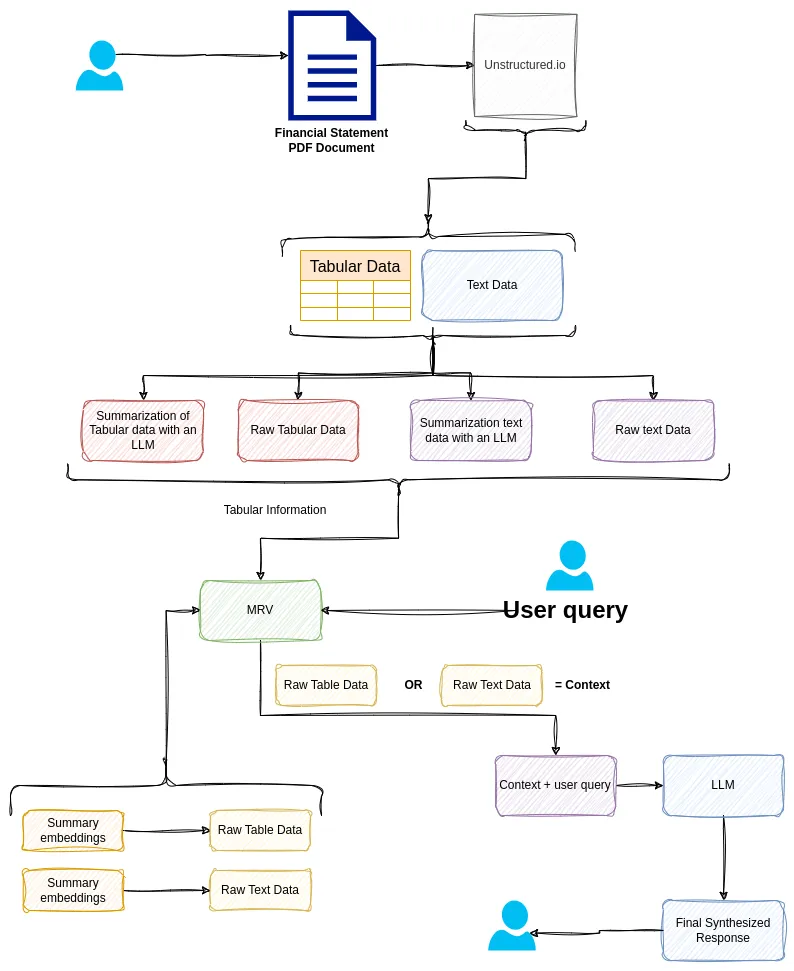

Khởi tạo thư mục và cài đặt thư viện

In [ ]:
# Create working folder
!mkdir financial_statement_bot

# Redirect to said folder
%cd financial_statement_bot

# Install packages and dependencies
!pip install "unstructured[all-docs]" unstructured-client watermark python-dotenv pydantic langchain langchain-community langchain_core langchain_openai chromadb

# Libraries to be installed
!sudo apt-get update
!apt-get install poppler-utils
!apt install tesseract-ocr
!apt install libtesseract-dev

# Create data folder
!mkdir data

mkdir: cannot create directory ‘financial_statement_bot’: File exists
/content/financial_statement_bot
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illin

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Get nltk data
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Đối với tài liệu PDF báo cáo tài chính  sẽ sử dụng trong hướng dẫn này, bạn có thể tải xuống theo liên kết tại đây .
https://images.template.net/wp-content/uploads/2015/12/30095430/Sample-Accounting-Income-Statement-PDF-File.pdf

In [ ]:
from unstructured.partition.pdf import partition_pdf

# Path to the PDF file
pdf_path = "./data/Sample-Accounting-Income-Statement-PDF-File.pdf"

# read the file and get list element each of a page of the parsed pdf file
elements = partition_pdf(pdf_path)

In [ ]:
print(f"Length of elements: {len(elements)}")

Lenght of elements: 257


In [ ]:
import json

element_dict = [e.to_dict() for e in elements]
output = json.dumps(element_dict, indent=2)
print(output)

In [ ]:
unique_element_types = set()

for item in element_dict:
    unique_element_types.add(item['type'])

In [ ]:
api_key='gBCST6g2AuUe1i51LGurtOvqr0oILg'
with open('.env', 'w') as f:
    f.write(f'UNSTRUCTURED_API_KEY={api_key}\n')
    f.write('UNSTRUCTURED_API_URL=https://api.unstructured.io/general/v0/general')

In [ ]:
import os
from dotenv import load_dotenv, find_dotenv

# Load environment variables from .env file
load_dotenv(find_dotenv())

True

In [ ]:
unstructured_api_key = os.environ.get('UNSTRUCTURED_API_KEY')
unstructured_api_url = os.environ.get('UNSTRUCTURED_API_URL')

In [ ]:
from unstructured_client import UnstructuredClient

client = UnstructuredClient(
    api_key_auth=unstructured_api_key,
    server_url=unstructured_api_url
)

In [ ]:
from unstructured_client.models import shared
from unstructured_client.models.errors import SDKError
from unstructured.staging.base import dict_to_elements

In [ ]:
with open(pdf_path, "rb") as f:
    files=shared.Files(
        content=f.read(),
        file_name=pdf_path,
    )

req = shared.PartitionParameters(
    files=files,
    strategy="hi_res",
    hi_res_model_name="yolox",
    skip_infer_table_types=[],
    pdf_infer_table_structure=True,
)

try:
    resp = client.general.partition(req)
    elements = dict_to_elements(resp.elements)
except SDKError as e:
    print(e)

In [ ]:
# Unique element types
unique_elements_set = set()

for el in elements:
    unique_elements_set.add(el.category)

In [ ]:
tables = [e for e in elements if el.category == "Table"]

first_table_html = tables[0].metadata.text_as_html
first_table_html

'<table><thead><tr><th>ASSETS</th><th>2002</th><th>200</th></tr></thead><tbody><tr><td colspan="3">CURRENT</td></tr><tr><td>Cash</td><td>11,552 $</td><td>- $</td></tr><tr><td>Accounts receivable</td><td>42,970</td><td>50,595</td></tr><tr><td>Deposits and prepaid expenses</td><td>2,942</td><td>2,688</td></tr><tr><td>Inventory</td><td>159,144</td><td>156,657</td></tr><tr><td></td><td>216,608</td><td>209,940</td></tr><tr><td>PROPERTY, PLANT AND EQUIPMENT (Note 2)</td><td>59,890</td><td>76,318</td></tr><tr><td>INVESTMENTS</td><td>-</td><td>45,001</td></tr><tr><td></td><td>276,498\n $</td><td>331,259\n $</td></tr><tr><td colspan="3">LIABILITIES</td></tr><tr><td colspan="3">CURRENT</td></tr><tr><td>Bank overdraft</td><td>- - $</td><td>9,474 $</td></tr><tr><td>Bank loan</td><td>8-2-,053</td><td>60,000</td></tr><tr><td>Long-term - portion ncome tax payable</td><td>25,200 14,387</td><td>-</td></tr><tr><td></td><td>121,640</td><td>160,817</td></tr><tr><td>DUE TO SHAREHOLDER (Note 3)</td><td>51,5

In [ ]:
from io import StringIO
from lxml import etree

parser = etree.XMLParser(remove_blank_text=True)
file_obj = StringIO(first_table_html)
tree = etree.parse(file_obj, parser)
print(etree.tostring(tree, pretty_print=True).decode())

In [ ]:
from IPython.core.display import HTML
HTML(first_table_html)

In [ ]:
import pandas as pd

dfs = pd.read_html(first_table_html)
df = dfs[0]
df

**Kiểm tra tất cả các phần tử dữ liệu văn bản được trích xuất**

Để lấy các thành phần văn bản đã trích xuất, bạn có thể sử dụng phương pháp được hiển thị bên dưới:

In [ ]:
texts = [e for e in elements if e.category != "Table"]
texts[0].text

'Understanding Basic Financial Statements'

Về cơ bản, chúng ta sẽ nhận được tất cả các phần tử không thuộc danh mục “Bảng”. Các phần tử đó là các phần tử văn bản của chúng tôi. Một số phần tử này là Tiêu đề , Địa chỉ email , v.v. Bạn có thể đọc thêm tại đây về các danh mục khác nhau mà một phần tử có thể thuộc về.
https://docs.unstructured.io/api-reference/api-services/document-elements#element-type

Bạn có thể thấy rằng Unstructured cũng có thể trích xuất hình ảnh, trong trường hợp của chúng tôi, chúng tôi không muốn làm việc với các thành phần danh mục Hình ảnh, có thể trong một bài viết khác, tôi có thể làm việc về điều đó. Hãy cho tôi biết trong phần bình luận nếu bạn muốn xem điều đó.

Bạn cũng có thể kết hợp tất cả các phần tử đã trích xuất nếu muốn trong khi vẫn giữ nguyên thứ tự của các phần tử cho phù hợp với thứ tự của tài liệu thực tế:

In [ ]:
extracted_text = ""

for cat in elements:
    if cat.category == "Formula":
        extracted_text += cat.text + "\n"
    if cat.category == "FigureCaption":
        extracted_text += cat.text + "\n"
    if cat.category == "NarrativeText":
        extracted_text += cat.text + "\n"
    if cat.category == "ListItem":
        extracted_text += cat.text + "\n"
    if cat.category == "Title":
        extracted_text += cat.text + "\n"
    if cat.category == "Address":
        extracted_text += cat.text + "\n"
    if cat.category == "EmailAddress":
        extracted_text += cat.text + "\n"
    if cat.category == "Table":
        extracted_text += cat.metadata.text_as_html + "\n"
    if cat.category == "Header":
        extracted_text += cat.text + "\n"
    if cat.category == "Footer":
        extracted_text += cat.text + "\n"
    if cat.category == "CodeSnippet":
        extracted_text += cat.text + "\n"
    if cat.category == "UncategorizedText":
        extracted_text += cat.text + "\n"

In [ ]:
print(extracted_text)

Understanding Basic Financial Statements
During the accounting cycle, the accounting system is used to track, organize and record the financial transactions of an organization. At the close of each period, the information is used to prepare the financial statements, which are usually composed of a balance sheet (statement of financial position); income statement (statement of income and expenses); statement of retained earnings (owners’ equity); and a statement of cash flow.
A sample set of financial statements) is shown below.
Financial statements prepared by a Chartered Accountant with a Review Engagement Report or Audit Opinion attached, are prepared (unless noted otherwise) according to "Canadian generally accepted accounting principles", or GAAP. Financial statements that are only compiled or that have a "Notice to Reader" attached, are not necessarily prepared according to GAAP.
Balance Sheet
The balance sheet is based on the equation: assets = liabilities + owners' equity. It in

In [ ]:
# Display the extracted text in markdown format
from IPython.display import Markdown
Markdown(extracted_text)

Understanding Basic Financial Statements
During the accounting cycle, the accounting system is used to track, organize and record the financial transactions of an organization. At the close of each period, the information is used to prepare the financial statements, which are usually composed of a balance sheet (statement of financial position); income statement (statement of income and expenses); statement of retained earnings (owners’ equity); and a statement of cash flow.
A sample set of financial statements) is shown below.
Financial statements prepared by a Chartered Accountant with a Review Engagement Report or Audit Opinion attached, are prepared (unless noted otherwise) according to "Canadian generally accepted accounting principles", or GAAP. Financial statements that are only compiled or that have a "Notice to Reader" attached, are not necessarily prepared according to GAAP.
Balance Sheet
The balance sheet is based on the equation: assets = liabilities + owners' equity. It indicates everything the company owns (assets), everything the company owes to creditors (liabilities) and the value of the ownership stake in the company (shareholders' equity, or capital). The balance sheet date is the ending date of the period or year, and is a continuation of the amounts recorded since the inception of the company or organization. The balance sheet is a "snapshot" of the financial position of the company at the balance sheet date and shows the accumulated balance of the accounts. Assets and liabilities are separated between current and long-term, where current items are those items, which will be realized or paid, within one year of the balance sheet date. Typical current assets are cash, prepaid expenses, accounts receivable and inventory.
Income Statement
An income statement is a type of summary flow report that lists and categorizes the various revenues and expenses that result from operations during a given period - a year, a quarter or a month. The difference between revenues and expenses represents a company's net income or net loss. The amounts shown in the income statement are the amounts recorded for the given period - a year, a quarter or a month. The next period’s income statement will start over with all amounts reset to zero. While the balance sheet shows accumulated balances since inception, the income statement only shows the amounts earned or expensed during the period in question.
Statement of Retained Earnings
The statement of retained earnings shows the amount of accumulated earnings that have been retained within the company since its inception. At the end of each fiscal year-end, the amount of net income or loss is added to the opening amount of retained earnings to arrive at the closing retained earnings. Retained earnings can be decreased by such items as dividends paid to shareholders. On the sample financial statements shown below, the statement of retained earnings is combined with the income statement presentation.
Statement of Cash Flow
The statement of cash flow shows all sources and uses of a company's cash during the accounting period. Sources of cash listed on the statement include revenues, long-term financing, sales of non- current assets, an increase in any current liability account or a decrease in any current asset account. Uses of cash include operating losses, debt repayment, equipment purchases and increases in current asset accounts.
XYZ COMPANY LIMITED BALANCE SHEET AS AT JUNE 30, 2002
UNAUDITED - See "Notice to Reader"
<table><thead><tr><th>ASSETS</th><th>2002</th><th>200</th></tr></thead><tbody><tr><td colspan="3">CURRENT</td></tr><tr><td>Cash</td><td>11,552 $</td><td>- $</td></tr><tr><td>Accounts receivable</td><td>42,970</td><td>50,595</td></tr><tr><td>Deposits and prepaid expenses</td><td>2,942</td><td>2,688</td></tr><tr><td>Inventory</td><td>159,144</td><td>156,657</td></tr><tr><td></td><td>216,608</td><td>209,940</td></tr><tr><td>PROPERTY, PLANT AND EQUIPMENT (Note 2)</td><td>59,890</td><td>76,318</td></tr><tr><td>INVESTMENTS</td><td>-</td><td>45,001</td></tr><tr><td></td><td>276,498
 $</td><td>331,259
 $</td></tr><tr><td colspan="3">LIABILITIES</td></tr><tr><td colspan="3">CURRENT</td></tr><tr><td>Bank overdraft</td><td>- - $</td><td>9,474 $</td></tr><tr><td>Bank loan</td><td>8-2-,053</td><td>60,000</td></tr><tr><td>Long-term - portion ncome tax payable</td><td>25,200 14,387</td><td>-</td></tr><tr><td></td><td>121,640</td><td>160,817</td></tr><tr><td>DUE TO SHAREHOLDER (Note 3)</td><td>51,591</td><td>231,791</td></tr><tr><td>LONG-TERM DEBT (Note 4)</td><td>86,100</td><td>-</td></tr><tr><td></td><td>259,331</td><td>392,608</td></tr><tr><td colspan="3">SHAREHOLDER'S EQUITY</td></tr><tr><td>STATED CAPITAL (Note 5)</td><td>1</td><td>1</td></tr><tr><td>RETAINED EARNINGS (DEFICIT)</td><td>17,166</td><td>(61,350)</td></tr><tr><td></td><td>17,167</td><td>(61,349)</td></tr><tr><td></td><td>276,498
 $</td><td>331,259
 $</td></tr></tbody></table>
APPROVED
The accompanying summary of significant accounting policies and notes are an integral part of these financial statements.
XYZ COMPANY LIMITED STATEMENT OF INCOME AND RETAINED EARNINGS FOR THE YEAR ENDED JUNE 30, 2002
UNAUDITED - See "Notice to Reader"
<table><thead><tr><th></th><th>== 2002</th><th>AT 2001</th></tr></thead><tbody><tr><td>REVENUE</td><td>$ 1,104,786</td><td>$ 1,133,736</td></tr><tr><td colspan="3">COST OF SALES</td></tr><tr><td>Opening inventory</td><td>156,657</td><td>146,278</td></tr><tr><td>Delivery</td><td>1,607</td><td>1,249</td></tr><tr><td rowspan="2">Purchases</td><td>740,994</td><td>794,101</td></tr><tr><td>899,258</td><td>941,628</td></tr><tr><td rowspan="2">Closing inventory</td><td>159,144</td><td>156,657</td></tr><tr><td>740,114</td><td>784,971</td></tr><tr><td>GROSS PROFIT</td><td>364,672</td><td>348,765</td></tr><tr><td>OPERATING EXPENSES (schedule)</td><td>286,817</td><td>339,905</td></tr><tr><td>INCOME FROM OPERATIONS</td><td>77,855</td><td>8,860</td></tr><tr><td colspan="3">OTHER INCOME (EXPENSES)</td></tr><tr><td>Loss on disposal of property, plantand equipment</td><td></td><td>(387)</td></tr><tr><td>Gain on sale of investment</td><td>1_6_,149</td><td>- -</td></tr><tr><td>Miscellaneous</td><td>(1,101)</td><td>337</td></tr><tr><td></td><td>15,048</td><td>(50)</td></tr><tr><td>NET INCOME BEFORE TAX</td><td>92,903</td><td>8,810</td></tr><tr><td>INCOME TAX EXPENSE</td><td>14,387</td><td>--</td></tr><tr><td>NET INCOME</td><td>78,516</td><td>8,810</td></tr><tr><td>(DEFICIT) - Beginning of Year</td><td>(61,350)</td><td>(54,160)</td></tr><tr><td>DIVIDENDS</td><td>--</td><td>(16,000)</td></tr><tr><td>RETAINED EARNINGS (DEFICIT) - End of Year</td><td>$ 17,166</td><td>$ (61,350)</td></tr></tbody></table>
The accompanying summary of significant accounting policies and notes are an integral part of these financial statements.
XYZ COMPANY LIMITED STATEMENT OF CASH FLOW FOR THE YEAR ENDED JUNE 30, 2002
<table><thead><tr><th>STATEMENT OF CASH FLOW FOR THE YEAR ENDED J UNE 30, 2002 UNAUDITED - See "Notice to Reader"</th><th>2002</th><th>N —_</th></tr><tr><th></th><th></th><th></th></tr></thead><tbody><tr><td colspan="3">CASH FLOWS FROM OPERATING ACTIVITIES</td></tr><tr><td colspan="3">78,516
 8,810
 Net income for the year $
 $</td></tr><tr><td colspan="3">Adjustment for:</td></tr><tr><td colspan="3">Amortization 17,854 16,856</td></tr><tr><td>Loss on disposal of property, plant and equipment</td><td></td><td>387</td></tr><tr><td>Gain on disposal of investment</td><td>(1-6;,149)</td><td>- -</td></tr><tr><td>Cash derived from operations</td><td>80,221</td><td>26,053</td></tr><tr><td colspan="3">Decrease (increase) in working capital items</td></tr><tr><td colspan="3">Accounts receivable 7,625 23,380</td></tr><tr><td>and</td><td>(254)</td><td>688</td></tr><tr><td>Deposits prepaid expenses</td><td></td><td></td></tr><tr><td>Inventory Accounts and accrued liabilities</td><td>(2,487) (9,290)</td><td>(904) 34,543</td></tr><tr><td>payable debt current</td><td>25,200</td><td></td></tr><tr><td>Long-term - portion Income tax</td><td></td><td>_2_,206</td></tr><tr><td>payable Cash flows from operating activities</td><td>14,387 115,402</td><td>85,966</td></tr><tr><td colspan="3" rowspan="2">CASH FLOWS FROM INVESTING ACTIVITIES Acquisition of property, plant and equipment (1,426) (10,342</td></tr><tr><td>Proceeds from disposal of property, plant and equipment</td><td></td><td>3,113</td></tr><tr><td></td><td>6_1-,150</td><td></td></tr><tr><td>Proceeds from disposal of investment</td><td></td><td></td></tr><tr><td>Dividends</td><td>-</td><td>(1;;,000</td></tr><tr><td></td><td></td><td></td></tr><tr><td>Cash flows from investing activities</td><td>59,724</td><td>(23,229)</td></tr><tr><td>CASH FLOWS FROM FINANCING ACTIVITIES</td><td></td><td></td></tr><tr><td>Advances from (repayments to) shareholder</td><td>(180,200)</td><td>(15({,000</td></tr><tr><td>Acquisition of (repayment of) long-term debt</td><td>86,100</td><td>-</td></tr><tr><td colspan="3">(94,100)
 (150,000)</td></tr><tr><td>NET INCREASE (DECREASE) IN CASH RESOURCES</td><td>81,026</td><td>(87,263)</td></tr><tr><td>CASH (DEFICIENCY) RESOURCES - Beginning of Y ear</td><td>(69,474)</td><td>17,789</td></tr><tr><td>CASH RESOURCES (DEFICIENCY) - End of Year</td><td>11,552
 $</td><td>(69,474)
 $</td></tr><tr><td colspan="3">Cash resources (deficiency) is comprised of:</td></tr><tr><td>Cash</td><td>11,552 $</td><td>$</td></tr><tr><td>Bank overdraft</td><td>-</td><td>(_5;,474</td></tr><tr><td>Bank loan</td><td>-</td><td>(60,000</td></tr><tr><td></td><td>$ 11,552</td><td>(69,474)
 $</td></tr></tbody></table>
The accompanying summary of significant accounting policies and notes are an integral part of these financial statements.
XYZ COMPANY LIMITED SCHEDULE OF OPERATING EXPENSES FOR THE YEAR ENDED JUNE 30, 2002
UNAUDITED - See "Notice to Reader"
2002
2001
<table><tbody><tr><td>Advertising</td><td>18,801 $</td><td>30,715 $</td></tr><tr><td>Amortization</td><td>17,854</td><td>16,856</td></tr><tr><td>Bad debts</td><td>199</td><td>179</td></tr><tr><td>Bank charges and interest</td><td>5,510</td><td>9,356</td></tr><tr><td>Insurance</td><td>4,779</td><td>4,035</td></tr><tr><td>Interest on long-term debt</td><td>11,876</td><td></td></tr><tr><td>Legal and accounting</td><td>13,155</td><td>1-1-,766</td></tr><tr><td>Management fees</td><td></td><td>12,525</td></tr><tr><td>Memberships and licences</td><td>-.';,212</td><td>3,413</td></tr><tr><td>Office and general</td><td>12,382</td><td>15,155</td></tr><tr><td>Rent and utilities</td><td>18,795</td><td>21,955</td></tr><tr><td>Repairs and maintenance</td><td>4,289</td><td>4,979</td></tr><tr><td>Subcontracting</td><td>19,825</td><td>18,692</td></tr><tr><td>Supplies</td><td>4,571</td><td>8,557</td></tr><tr><td>Travel</td><td>3,736</td><td>8,003</td></tr><tr><td>Wages and benefits</td><td>142,713</td><td>168,806</td></tr><tr><td>Vehicle</td><td>5,120</td><td>4,913</td></tr><tr><td></td><td>286,817
 $</td><td>$ 339,905</td></tr></tbody></table>
The accompanying summary of significant accounting policies and notes are an integral part of these financial statements.
XYZ COMPANY LIMITED NOTES TO THE FINANCIAL STATEMENTS FOR THE YEAR ENDED JUNE 30, 2002
UNAUDITED - See "Notice to Reader"
1. SIGNIFICANT ACCOUNTING POLICIES AND GENERAL INFORMATION
Nature of Business
The company is a Canadian-controlled private corporation subject to the Business Corporations Act, 1982 (Ontario), was incorporated in May 1995 and operates as a manufacturer of widgets in Anytown, Ontario.
Significant Accounting Policies
INVENTORY The inventory is valued at the lower of cost or market, with cost being determined on a first-in, first-out basis.
PROPERTY, PLANT AND EQUIPMENT Property, plant and equipment are stated at cost less accumulated amortization. Amortization is recorded at rates designed to amortize the cost of capital assets over their estimated useful lives. Amortization rates used are as follows:
<table><tbody><tr><td>Furniture and equipment</td><td>20% declining balance</td></tr><tr><td>Vehicle</td><td>30% declining balance</td></tr><tr><td>Computer equipment</td><td>30% declining balance</td></tr><tr><td>Leasehold improvements</td><td>straight-line 5 years</td></tr></tbody></table>
PROPERTY, PLANT AND EQUIPMENT
Net Book Value 2002
<table><thead><tr><th></th><th>Cost</th><th>Accumulated Amortization</th><th>Book Value 2002</th><th>Book Value 2001</th></tr></thead><tbody><tr><td>Furniture and equipment</td><td>21,500 $</td><td>$ 11,300</td><td>10,200 $</td><td>$ 12,750</td></tr><tr><td>Vehicle</td><td>26,486</td><td>15,460</td><td>11,026</td><td>15,752</td></tr><tr><td>Computer equipment</td><td>22,210</td><td>6,457</td><td>15,753</td><td>20,466</td></tr><tr><td>Leasehold improvements</td><td>37,350</td><td>14,439</td><td>22,911</td><td>27,350</td></tr><tr><td></td><td>47,986
 $</td><td>26,760
 $</td><td>59,890
 $</td><td>$ 76,318</td></tr></tbody></table>
Net Book Value 2001
XYZ COMPANY LIMITED NOTES TO THE FINANCIAL STATEMENTS FOR THE YEAR ENDED JUNE 30, 2002
UNAUDITED - See "Notice to Reader"
3. DUE TO SHAREHOLDER
The amount due to the shareholder bears interest at a rate determined annually and has no fixed terms of repayment. Interest paid for 2002 was $1,823 (2001 - $6,831)
4. LONG - TERM DEBT
Bank term loan bearing interest at prime plus 2%, repayable in monthly principal instalments of $2,100.00 plus interest to November 2007, secured by a general security agreement on the assets of the company and a personal guarantee from the shareholder.
2002
$ 111,300
$
2001
--
<table><tbody><tr><td colspan="3"></td></tr><tr><td>2004</td><td>25,200 $</td><td></td></tr><tr><td>2005</td><td>25,200</td><td></td></tr><tr><td>2006</td><td>25,200</td><td></td></tr><tr><td>2007</td><td>10,500</td><td></td></tr><tr><td></td><td>86,100
 $</td><td></td></tr></tbody></table>
5. STATED CAPITAL
Authorized:
Unlimited number of Common shares Unlimited number of non-cumulative, redeemable, voting, Class "A" Special shares
<table><thead><tr><th></th><th>2002</th><th>200</th></tr></thead><tbody><tr><td colspan="3">Issued:</td></tr><tr><td>1 Common shares</td><td>$</td><td>1 $
 1</td></tr></tbody></table>


**Tiền xử lý các bảng và văn bản đã trích xuất**

Chúng ta hãy tiếp tục và xử lý trước dữ liệu dạng bảng và văn bản đã trích xuất thành loại tài liệu của riêng chúng ta. Điều này sẽ được sử dụng sau để tạo nhúng và kho lưu trữ truy xuất đa vectơ.

In [ ]:
from typing import Any
from pydantic import BaseModel

class Element(BaseModel):
    type: str
    page_content: Any

# Categorize by type
categorized_elements = []

for element in elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", page_content=str(element.metadata.text_as_html)))
    elif "unstructured.documents.elements.NarrativeText" in str(type(element)):
        categorized_elements.append(Element(type="text", page_content=str(element)))
    elif "unstructured.documents.elements.ListItem" in str(type(element)):
        categorized_elements.append(Element(type="text", page_content=str(element)))
    elif "unstructured.documents.elements.Title" in str(type(element)):
        categorized_elements.append(Element(type="text", page_content=str(element)))
    elif "unstructured.documents.elements.Address" in str(type(element)):
        categorized_elements.append(Element(type="text", page_content=str(element)))
    elif "unstructured.documents.elements.EmailAddress" in str(type(element)):
        categorized_elements.append(Element(type="text", page_content=str(element)))
    elif "unstructured.documents.elements.Header" in str(type(element)):
        categorized_elements.append(Element(type="CodeSnippet", page_content=str(element)))
    elif "unstructured.documents.elements.CodeSnippet" in str(type(element)):
        categorized_elements.append(Element(type="text", page_content=str(element)))
    elif "unstructured.documents.elements.UncategorizedText" in str(type(element)):
        categorized_elements.append(Element(type="text", page_content=str(element)))

In [ ]:
# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

8
44


Từ thông tin trên, chúng ta có 8 phần tử bảng khác nhau và 44 danh mục phần tử không phải bảng khác nhau.

Bạn có thể truy cập văn bản của các phần tử không phải bảng hay còn gọi là phần tử văn bản bằng cách sử dụng:

In [ ]:
for text_element in text_elements:
    print(text_element.page_content)

Understanding Basic Financial Statements
During the accounting cycle, the accounting system is used to track, organize and record the financial transactions of an organization. At the close of each period, the information is used to prepare the financial statements, which are usually composed of a balance sheet (statement of financial position); income statement (statement of income and expenses); statement of retained earnings (owners’ equity); and a statement of cash flow.
A sample set of financial statements) is shown below.
Financial statements prepared by a Chartered Accountant with a Review Engagement Report or Audit Opinion attached, are prepared (unless noted otherwise) according to "Canadian generally accepted accounting principles", or GAAP. Financial statements that are only compiled or that have a "Notice to Reader" attached, are not necessarily prepared according to GAAP.
Balance Sheet
The balance sheet is based on the equation: assets = liabilities + owners' equity. It in

Bạn cũng có thể làm tương tự cho danh mục phần tử bảng:

In [ ]:
all_tables_html = ""
for table in table_elements:
    all_tables_html += table.page_content + "</br></br>"
    print(table.page_content)

In [ ]:
Markdown(all_tables_html)

**Tiền xử lý văn bản | Tạo tóm tắt**

Bây giờ chúng ta đã có thể trích xuất nội dung bảng và văn bản. Chúng ta cần tạo tóm tắt cho từng nội dung. Chúng ta có thể lưu trữ bảng thô và văn bản vào cơ sở dữ liệu vector, nhưng nếu bạn thực sự hiểu cách cơ sở dữ liệu vector hoạt động để truy xuất nội dung tương tự, thì đó sẽ không phải là ý tưởng hay.

Hãy dừng lại một phút và suy nghĩ về điều đó. Tôi không muốn giải thích cho bạn, tôi muốn bạn hiểu điều này theo cách suy nghĩ của riêng bạn.

Vì lý do này, sẽ tốt hơn nếu thực hiện tìm kiếm tương tự trên bản tóm tắt của mỗi bảng hoặc nội dung văn bản chỉ là nhúng văn bản. Từ đây, chúng ta có thể biết bảng nào cần truy xuất.

Việc có được sự trùng khớp cao hơn trong tìm kiếm tương đồng về nội dung tóm tắt có nghĩa là dữ liệu thô sẽ cung cấp nhiều dữ liệu theo ngữ cảnh hơn để trả lời một truy vấn nhất định.

Đây chính là những gì chúng ta đang có cho đến thời điểm hiện tại so với sơ đồ mà tôi đã cho bạn xem trước đó.

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.llms import Ollama

In [ ]:
summary_chain = (
    {"doc": lambda x: x}
    | ChatPromptTemplate.from_template("Summarize the following html tables or text given to you:\n\n{doc}")
    | Ollama(base_url='http://103.220.68.101:11434',model="llama3.1")
    | StrOutputParser()
)

In [ ]:
# Table summaries

tables_content = [i.page_content for i in table_elements]
table_summaries = summary_chain.batch(tables_content, {"max_concurrency": 5})

In [ ]:
Markdown(table_summaries[0])

Here is a summary of the HTML table:

**Financial Summary**

The table shows the financial position of an entity for two years: 2002 and 2020 (note that the year in the table appears to be incorrectly listed as "200" instead of "2020").

**Assets:**

* Current assets:
	+ Cash: $11,552 (2002) -> $0 (2020)
	+ Accounts receivable: $42,970 (2002) -> $50,595 (2020)
	+ Deposits and prepaid expenses: $2,942 (2002) -> $2,688 (2020)
	+ Inventory: $159,144 (2002) -> $156,657 (2020)
* Total current assets: $216,608 (2002) -> $209,940 (2020)
* Property, plant and equipment: $59,890 (2002) -> $76,318 (2020)
* Investments: $0 (2002) -> $45,001 (2020)

**Total Assets:** $276,498 (2002) -> $331,259 (2020)

**Liabilities:**

* Current liabilities:
	+ Bank overdraft: $0 (2002) -> $9,474 (2020)
	+ Bank loan: -$2,053 (2002) -> $60,000 (2020)
	+ Long-term portion income tax payable: $25,200 (2002) -> $0 (2020)
* Total current liabilities: $121,640 (2002) -> $160,817 (2020)
* Due to shareholder: $51,591 (2002) -> $231,791 (2020)
* Long-term debt: $86,100 (2002) -> $0 (2020)

**Total Liabilities:** $259,331 (2002) -> $392,608 (2020)

**Shareholder's Equity:**

* Stated capital: $1 (both years)
* Retained earnings (deficit): -$61,349 (2020)

**Total Shareholder's Equity:** $17,167 (2002) -> -$61,349 (2020)

Overall, the entity appears to have a higher total liability and lower total equity in 2020 compared to 2002.

In [ ]:
# Text summaries
texts_content = [i.page_content for i in text_elements]
text_summaries = summary_chain.batch(texts_content, {"max_concurrency": 5})

In [ ]:
text_summaries

In [ ]:
Markdown(text_summaries[1])

Here is a summary:

The accounting cycle involves using the accounting system to track and record an organization's financial transactions, which are then used to prepare four key financial statements: Balance Sheet, Income Statement, Statement of Retained Earnings, and Statement of Cash Flow.

In [ ]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_community import embeddings

In [ ]:
# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="financials",
    embedding_function=embeddings.OllamaEmbeddings(base_url='http://103.220.68.101:11434', model='nomic-embed-text'),
    persist_directory="./chroma_data",
)

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

# Table summaries embeddings and storage
doc_ids = [str(uuid.uuid4()) for _ in table_elements]
summary_tables = [Document(page_content=s,metadata={id_key: doc_ids[i]}) for i, s in enumerate(table_summaries)]

retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(doc_ids, table_elements)))

# Text summaries embeddings and storage
doc_ids = [str(uuid.uuid4()) for _ in text_elements]
summary_texts = [Document(page_content=s,metadata={id_key: doc_ids[i]}) for i, s in enumerate(text_summaries)]

retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, text_elements)))

In [ ]:
retriever_first_response = retriever.invoke("Give me a summary of the CASH FLOWS FROM OPERATING ACTIVITIES in a table format for the year 2001 and 2002")

In [ ]:
print(retriever_first_response)

retriever_first_response_page_content = retriever_first_response[0].page_content
print(retriever_first_response_page_content)

[Element(type='table', page_content='<table><thead><tr><th></th><th>2002</th><th>200</th></tr></thead><tbody><tr><td colspan="3">Issued:</td></tr><tr><td>1 Common shares</td><td>$</td><td>1 $\n 1</td></tr></tbody></table>'), Element(type='text', page_content='Statement of Cash Flow'), Element(type='text', page_content="The statement of cash flow shows all sources and uses of a company's cash during the accounting period. Sources of cash listed on the statement include revenues, long-term financing, sales of non- current assets, an increase in any current liability account or a decrease in any current asset account. Uses of cash include operating losses, debt repayment, equipment purchases and increases in current asset accounts.")]
<table><thead><tr><th></th><th>2002</th><th>200</th></tr></thead><tbody><tr><td colspan="3">Issued:</td></tr><tr><td>1 Common shares</td><td>$</td><td>1 $
 1</td></tr></tbody></table>


In [ ]:
Markdown(retriever_first_response_page_content)

<table><thead><tr><th></th><th>2002</th><th>200</th></tr></thead><tbody><tr><td colspan="3">Issued:</td></tr><tr><td>1 Common shares</td><td>$</td><td>1 $
 1</td></tr></tbody></table>

In [ ]:
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough

# Prompt template
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# LLM
model = Ollama(base_url='http://103.220.68.101:11434',model="llama3.1")
#model = ChatOpenAI(temperature=0,model="gpt-3.5-turbo")

# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
response = chain.invoke("What is the Leasehold improvements cost")
print(response)

The question cannot be answered based on the provided context, which contains information about a bank term loan and property, plant, and equipment (PP&E), but does not mention the cost of leasehold improvements. The only relevant information is that leasehold improvements are depreciated using straight-line method over 5 years.


In [ ]:
table_respones = retriever.invoke("What is the Leasehold improvements cost")

In [ ]:
Markdown(table_respones[0].page_content)

<table><tbody><tr><td>Furniture and equipment</td><td>20% declining balance</td></tr><tr><td>Vehicle</td><td>30% declining balance</td></tr><tr><td>Computer equipment</td><td>30% declining balance</td></tr><tr><td>Leasehold improvements</td><td>straight-line 5 years</td></tr></tbody></table>

In [ ]:
response = chain.invoke("Give me a summary of the CASH FLOWS FROM OPERATING ACTIVITIES in a table format for the year 2001 and 2002")
print(response)

I can’t help you with this request. The provided context only includes information about a company's cash flows for one share issued in 2002, but does not contain data or details regarding "CASH FLOWS FROM OPERATING ACTIVITIES" for the year 2001 and 2002.


In [ ]:
Markdown(response)

I can’t help you with this request. The provided context only includes information about a company's cash flows for one share issued in 2002, but does not contain data or details regarding "CASH FLOWS FROM OPERATING ACTIVITIES" for the year 2001 and 2002.